# Self-Play

**Self-play** is the core training mechanism in AlphaZero where the AI plays against itself to generate training data and improve over time. This notebook explains how self-play works and how it combines MCTS and neural networks to create a continuously improving system.

1. **Plays games against itself** using MCTS guided by a neural network
2. **Records training examples** from each game (states, MCTS policies, outcomes)
3. **Trains the neural network** on these examples to improve predictions
4. **Repeats** the process, getting progressively stronger

This creates a virtuous cycle

<!-- better network → better MCTS → better training data → better network. -->

```mermaid
---
config:
  theme: 'base'
  themeVariables:
    primaryColor: '#ffffff'
    primaryTextColor: '#4D5461'
    primaryBorderColor: '#096bda11'
    lineColor: '#096bda'
    secondaryColor: '#ffffff84'
    secondaryTextColor: '#4D5461'
    tertiaryColor: '#4d546110'
    tertiaryTextColor: '#4D5461'
---
stateDiagram-v2
    s1: Better Neural Network
    s2: Better MCTS
    s3: Better Training Data

    s1 --> s2
    s2 --> s3
    s3 --> s1
```

### The Loop
```mermaid
---
config:
  theme: 'base'
  themeVariables:
    primaryColor: '#ffffff'
    primaryTextColor: '#4D5461'
    primaryBorderColor: '#096bda11'
    lineColor: '#096bda'
    secondaryColor: '#ffffff84'
    secondaryTextColor: '#4D5461'
    tertiaryColor: '#4d546110'
    tertiaryTextColor: '#4D5461'
---
graph TD
    A[Initialize Game] --> B[MCTS Search]
    B --> C[Get Move Probabilities]
    C --> D[Sample Action]
    D --> E[Make Move]
    E --> F{Game Over?}
    F -->|No| B
    F -->|Yes| G[Record Game Outcome]
    G --> H[Create Training Examples]
    H --> I[Train Network]
    I --> A
```

*Note: The diagram above illustrates the self-play loop where the agent continuously plays games against itself, collects data, and trains its neural network to improve performance over time. Self-play and Neural Network Training could be done parallely in practice for efficiency. For the purpose of clarity, they are shown sequentially here.*

## Advanced Techniques

Before diving into the full self-play implementation, let's understand some critical techniques that make AlphaZero training effective:

1. **Temperature**: Controls exploration vs exploitation during move selection
2. **Dirichlet Noise**: Adds randomness at the root to ensure diverse openings
3. **Replay Buffer**: Stores and reuses training examples across iterations
4. **Data Augmentation**: Multiplies training data using symmetries

These techniques are essential for stable learning and preventing overfitting.

### 1. Temperature: Exploration vs Exploitation

**Temperature** $\tau$ controls how deterministically we select moves from MCTS visit counts.


Temperature controls exploration vs exploitation:
- **High temperature (1.0)**: Early game, explore different openings
- **Low temperature (0.0)**: Late game, play the best move deterministically
- We typically use temperature 1.0 for the first 3-5 moves, then switch to 0.0, in the case of Tic-Tac-Toe. Other games may require different schedules.

Given visit counts $N(s,a)$ for each action $a$:

$$\pi(a|s) = \frac{N(s,a)^{1/\tau}}{\sum_b N(s,b)^{1/\tau}}$$

Temperature does not have an upper bound, but values above 1.0 are rarely used in practice. This is same temperature concept used in LLMs for sampling.

**Temperature Values**

- **$\tau = 1.0$** (high): Probability proportional to visit counts
  - Explores multiple promising moves
  - Used in opening moves to build diverse opening book
  
- **$\tau = 0.0$** (low): Deterministic selection
  - Always picks the most-visited move
  - Used in critical positions and endgame



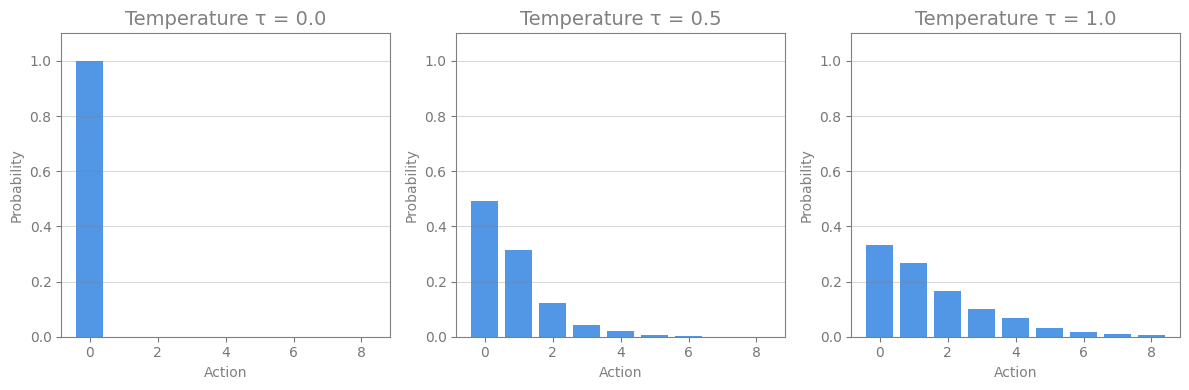

In [1]:
# Demonstration: Temperature effect on move selection
import numpy as np
import matplotlib.pyplot as plt

# Simulate visit counts from MCTS
visit_counts = np.array([100, 80, 50, 30, 20, 10, 5, 3, 2])  # 9 possible moves
actions = list(range(9))


def apply_temperature(visit_counts, temperature):
    """Apply temperature to visit counts to get probabilities"""
    if temperature == 0:
        # Greedy: pick most visited
        probs = np.zeros_like(visit_counts, dtype=float)
        probs[np.argmax(visit_counts)] = 1.0
        return probs
    else:
        # Softmax with temperature
        counts_temp = visit_counts ** (1.0 / temperature)
        return counts_temp / np.sum(counts_temp)


# Compare different temperatures
temperatures = [0.0, 0.5, 1.0]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

fig.patch.set_facecolor("none")
for idx, temp in enumerate(temperatures):
    probs = apply_temperature(visit_counts, temp)
    axes[idx].bar(actions, probs, color="#096bda", alpha=0.7)
    axes[idx].set_title(f"Temperature τ = {temp}", fontsize=14, color="#808080")
    axes[idx].set_xlabel("Action", color="#808080")
    axes[idx].set_ylabel("Probability", color="#808080")
    axes[idx].set_ylim(0, 1.1)
    axes[idx].grid(axis="y", alpha=0.3, color="#808080")
    axes[idx].spines["bottom"].set_color("#808080")
    axes[idx].spines["top"].set_color("#808080")
    axes[idx].spines["left"].set_color("#808080")
    axes[idx].spines["right"].set_color("#808080")
    axes[idx].set_facecolor("none")
    axes[idx].tick_params(colors="#777777", which="both")

fig.set_alpha(0)
plt.tight_layout()
plt.show()


Note that for temperature $\tau > 0$, the probablity of selecting other moves is non-zero, allowing for exploration of less-visited actions.

**Temperature Annealing Schedule**

In [2]:
def compute_temperature(iteration, move_number):
    # Early iterations: explore more
    if iteration < 100:
        if move_number < 3:
            return 1.0  # High exploration in opening
        else:
            return 0.0  # Deterministic after opening
    else:
        # Later iterations: mostly deterministic
        return 0.0

### 2. Dirichlet Noise: Ensuring Exploration at Root

In $\alpha$MCTS, the neural network can sometimes be "too confident" in its policy predictions, causing the search to narrow down prematurely. Dirichlet noise is a mechanism introduced to counteract this by enforcing diverse exploration, particularly during the opening phase of the game.

Unlike Temperature, which affects how a final move is selected after the MCTS simulation (based on visit counts), Dirichlet noise is applied before the search begins. It directly perturbs the prior probabilities output by the neural network, but only at the root node.

**The Mechanism**

The prior probabilities are modified by mixing the neural network’s output with a noise vector drawn from a Dirichlet distribution. The formula ensures that the resulting values still sum to 1 (valid probabilities) while introducing controlled randomness.
At the root node only, we modify the prior probabilities:

$$P'(s,a) = (1 - \epsilon) \cdot P(s,a) + \epsilon \cdot \eta_a$$

Where:
- $P(s,a)$: The original policy probability from the neural network.
- $\eta \sim \text{Dir}(\alpha)$:The noise vector drawn from the Dirichlet distribution.
- $\alpha = 0.3$: Concentration parameter 
- $\epsilon = 0.25$: The mixing weight. This dictates the balance; typically, the prior is 75% network policy and 25% noise.

**Understanding the Intuition**

The Dirichlet distribution is chosen because it is perfect for generating random probability distributions. The behavior of the noise depends heavily on the concentration parameter ($\alpha$):Small $\alpha$ (e.g., 0.3 for Chess): Produces "spiky" or sparse distributions. This means the noise will heavily boost one or two specific moves while suppressing others. This encourages the search to seriously consider a specific alternative line of play.Large $\alpha$ (e.g., 10): Produces "flat" or uniform distributions. This would add a small amount of noise to every move equally, which is generally less useful for strategic exploration.

**Why is this crucial?**

Without Dirichlet noise, the agent suffers from confirmation bias. If the neural network initially assigns a very low probability to a strong move (perhaps due to a blind spot in its training), the MCTS will rarely explore it. By artificially boosting priors at the root, Dirichlet noise forces the search to analyze moves the network might have initially underestimated.

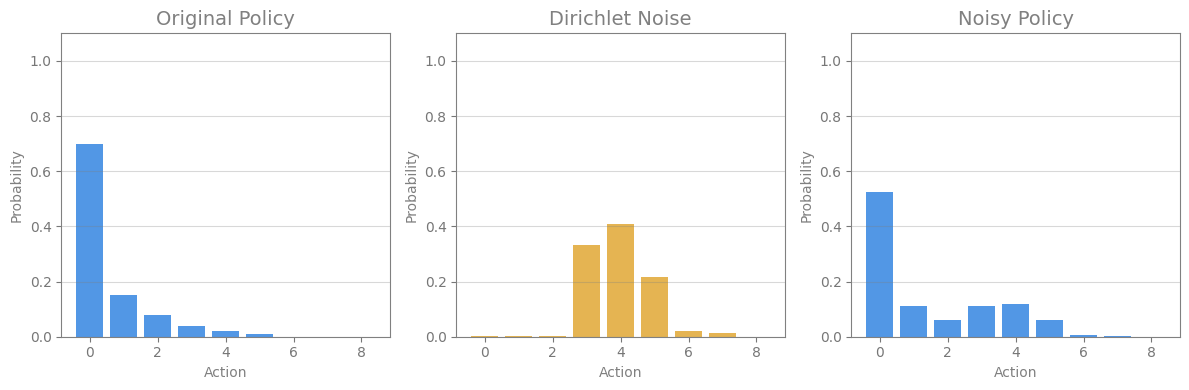

In [3]:
# Example: Network suggests a strong preference for action 0


def apply_dirichlet_noise(policy_probs, alpha=0.3, epsilon=0.25):
    num_actions = len(policy_probs)
    # numpy's dirichlet function
    noise = np.random.dirichlet([alpha] * num_actions)
    noisy_policy = (1 - epsilon) * policy_probs + epsilon * noise
    return noisy_policy, noise


original_policy = np.array([0.7, 0.15, 0.08, 0.04, 0.02, 0.01, 0.0, 0.0, 0.0])
noisy_policy, noise = apply_dirichlet_noise(original_policy)

# Plot original, noise and noisy policies
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()
fig.patch.set_facecolor("none")
axes[0].bar(range(len(original_policy)), original_policy, color="#096bda", alpha=0.7)
axes[0].set_title("Original Policy", fontsize=14, color="#808080")
axes[0].set_xlabel("Action", color="#808080")
axes[0].set_ylabel("Probability", color="#808080")
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis="y", alpha=0.3, color="#808080")
axes[0].spines["bottom"].set_color("#808080")
axes[0].spines["top"].set_color("#808080")
axes[0].spines["left"].set_color("#808080")
axes[0].spines["right"].set_color("#808080")
axes[0].set_facecolor("none")
axes[0].tick_params(colors="#777777", which="both")

axes[1].bar(range(len(noise)), noise, color="#da9509", alpha=0.7)
axes[1].set_title("Dirichlet Noise", fontsize=14, color="#808080")
axes[1].set_xlabel("Action", color="#808080")
axes[1].set_ylabel("Probability", color="#808080")
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis="y", alpha=0.3, color="#808080")
axes[1].spines["bottom"].set_color("#808080")
axes[1].spines["top"].set_color("#808080")
axes[1].spines["left"].set_color("#808080")
axes[1].spines["right"].set_color("#808080")
axes[1].set_facecolor("none")
axes[1].tick_params(colors="#777777", which="both")

axes[2].bar(range(len(noisy_policy)), noisy_policy, color="#096bda", alpha=0.7)
axes[2].set_title("Noisy Policy", fontsize=14, color="#808080")
axes[2].set_xlabel("Action", color="#808080")
axes[2].set_ylabel("Probability", color="#808080")
axes[2].set_ylim(0, 1.1)
axes[2].grid(axis="y", alpha=0.3, color="#808080")
axes[2].spines["bottom"].set_color("#808080")
axes[2].spines["top"].set_color("#808080")
axes[2].spines["left"].set_color("#808080")
axes[2].spines["right"].set_color("#808080")
axes[2].set_facecolor("none")
axes[2].tick_params(colors="#777777", which="both")

fig.set_alpha(0)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np


def apply_dirichlet_noise(policy_probs, alpha=0.3, epsilon=0.25):
    num_actions = len(policy_probs)
    # numpy's dirichlet function
    noise = np.random.dirichlet([alpha] * num_actions)
    noisy_policy = (1 - epsilon) * policy_probs + epsilon * noise
    return noisy_policy, noise

### 3. Replay Buffer

The replay buffer in AlphaZero is a training data storage mechanism, First-In, First-Out (FIFO queue), that stores game experiences generated during self-play. 

We maintain a buffer of the last $N$ examples (e.g., 50,000). When training, we sample a random mini-batch from this buffer. This mixes positions from the current iteration with positions from several iterations ago.

**Breaks Temporal Correlation:**

Consecutive positions in a game are highly correlated. Neural networks learn best from Independent and Identically Distributed (IID) data. Training on correlated data causes the network to "chase its tail," leading to unstable learning.

**Increases Sample Efficiency & Stabilizes Learning:**

Instead of discarding an experience after using it once, the replay buffer allows the agent to reuse past data multiple times for training updates, making the learning process more efficient.
Averaging the gradients over a diverse set of uncorrelated examples reduces the variance of the updates.

In [5]:
import numpy as np


class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = []
        self.capacity = capacity

    def add(self, example):
        self.buffer.append(example)
        # FIFO: Remove oldest if over capacity
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]


### 4. Data Augmentation: Exploiting Symmetries

It involves multiplying the training data by applying valid geometric transformations (symmetries) to the game states. In many games, including Tic-Tac-Toe, the board has symmetries (rotations and reflections) that do not change the fundamental nature of the position. By leveraging these symmetries, we can effectively increase the size of our training dataset without needing additional self-play games.

This does not work for all games. In games like Chess or Go, symmetries are more limited due to asymmetrical starting positions and piece values. However, for Tic-Tac-Toe, we can use all 8 symmetries (4 rotations and 4 reflections).

It is crucial that when we transform the Board State, we must also transform the Policy (Target Probabilities) to match.

In [6]:
from IPython.display import display, HTML
import json
import random


class DataAugmentationDemo:
    def __init__(self):
        self.size = 160
        self.padding = 16
        self.cell_size = (self.size - self.padding * 2) / 3
        self.widget_id = f"aug_{random.randint(1000, 9999)}"

    def generate_html(self):
        html = f"""
<div id="{self.widget_id}_container" 
     style="font-family: sans-serif; max-width: 1000px; margin: 0 auto; padding: 20px; color: var(--text);">
  
  <div style="padding: 20px; margin-bottom: 20px;">
    <p style="text-align: center; font-size: 13px; margin-bottom: 16px; color: #666;">
      Click on the <strong>Identity</strong> board to place X or O pieces.<br>
      Watch how all 8 transformations update.
    </p>
  </div>

  <div id="{self.widget_id}_boards" style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 20px; margin-bottom: 20px;">
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_0" width="{self.size}" height="{self.size + 30}" style="display:block; border: 1px solid #e1e4e8;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Identity (Click Here)</text>
        <g id="{self.widget_id}_board_0_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_1" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Rotate 90°</text>
        <g id="{self.widget_id}_board_1_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_2" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Rotate 180°</text>
        <g id="{self.widget_id}_board_2_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_3" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Rotate 270°</text>
        <g id="{self.widget_id}_board_3_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_4" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Flip Horizontal</text>
        <g id="{self.widget_id}_board_4_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_5" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Flip Vertical</text>
        <g id="{self.widget_id}_board_5_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_6" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Flip Diagonal \\</text>
        <g id="{self.widget_id}_board_6_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
    <div style="text-align: center;">
      <svg id="{self.widget_id}_board_7" width="{self.size}" height="{self.size + 30}" style="display:block;">
        <text x="{self.size / 2}" y="14" text-anchor="middle" 
              fill="#4D5461" font-family="sans-serif" font-size="12" font-weight="600">Flip Diagonal /</text>
        <g id="{self.widget_id}_board_7_content" transform="translate(0, 20)"></g>
      </svg>
    </div>
  </div>


</div>

<script>
(function() {{
  const widgetId = '{self.widget_id}';
  const size = {self.size};
  const padding = {self.padding};
  const cellSize = {self.cell_size};
  
  // State: 0=empty, 1=X, -1=O
  let state = [0, 1, 0, 0, 1, -1, 0, -1, 1];
  let currentPlayer = 1; // 1=X, -1=O
  
  // Transformation maps: how to transform index i
  const transforms = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8],  // Identity
    [6, 3, 0, 7, 4, 1, 8, 5, 2],  // Rotate 90°
    [8, 7, 6, 5, 4, 3, 2, 1, 0],  // Rotate 180°
    [2, 5, 8, 1, 4, 7, 0, 3, 6],  // Rotate 270°
    [2, 1, 0, 5, 4, 3, 8, 7, 6],  // Flip H
    [6, 7, 8, 3, 4, 5, 0, 1, 2],  // Flip V
    [0, 3, 6, 1, 4, 7, 2, 5, 8],  // Flip D1
    [8, 5, 2, 7, 4, 1, 6, 3, 0],  // Flip D2
  ];
  
  function applyTransform(state, transformMap) {{
    const newState = new Array(9).fill(0);
    for (let i = 0; i < 9; i++) {{
      newState[transformMap[i]] = state[i];
    }}
    return newState;
  }}
  
  function drawBoard(boardIdx, boardState) {{
    const svg = document.getElementById(`${{widgetId}}_board_${{boardIdx}}_content`);
    if (!svg) return;
    
    // Clear
    while (svg.firstChild) {{
      svg.removeChild(svg.firstChild);
    }}
    
    // Grid lines
    for (let i = 1; i < 3; i++) {{
      const x = padding + i * cellSize;
      const y = padding + i * cellSize;
      
      const vLine = document.createElementNS('http://www.w3.org/2000/svg', 'line');
      vLine.setAttribute('x1', x);
      vLine.setAttribute('y1', padding);
      vLine.setAttribute('x2', x);
      vLine.setAttribute('y2', size - padding);
      vLine.setAttribute('stroke', '#666');
      vLine.setAttribute('stroke-width', '2');
      svg.appendChild(vLine);
      
      const hLine = document.createElementNS('http://www.w3.org/2000/svg', 'line');
      hLine.setAttribute('x1', padding);
      hLine.setAttribute('y1', y);
      hLine.setAttribute('x2', size - padding);
      hLine.setAttribute('y2', y);
      hLine.setAttribute('stroke', '#666');
      hLine.setAttribute('stroke-width', '2');
      svg.appendChild(hLine);
    }}
    
    // Draw cells
    for (let i = 0; i < 9; i++) {{
      const row = Math.floor(i / 3);
      const col = i % 3;
      const x = padding + col * cellSize;
      const y = padding + row * cellSize;
      const cx = x + cellSize / 2;
      const cy = y + cellSize / 2;
      
      // Clickable area only on Identity board (boardIdx === 0)
      if (boardIdx === 0) {{
        const clickRect = document.createElementNS('http://www.w3.org/2000/svg', 'rect');
        clickRect.setAttribute('x', x);
        clickRect.setAttribute('y', y);
        clickRect.setAttribute('width', cellSize);
        clickRect.setAttribute('height', cellSize);
        clickRect.setAttribute('fill', 'transparent');
        clickRect.setAttribute('stroke', 'none');
        clickRect.style.cursor = 'pointer';
        clickRect.addEventListener('click', () => handleClick(i));
        svg.appendChild(clickRect);
      }}
      
      // Draw piece
      if (boardState[i] === 1) {{
        // X
        const sizeX = cellSize * 0.4;
        
        const line1 = document.createElementNS('http://www.w3.org/2000/svg', 'line');
        line1.setAttribute('x1', cx - sizeX / 2);
        line1.setAttribute('y1', cy - sizeX / 2);
        line1.setAttribute('x2', cx + sizeX / 2);
        line1.setAttribute('y2', cy + sizeX / 2);
        line1.setAttribute('stroke', '#0969da');
        line1.setAttribute('stroke-width', '3');
        line1.setAttribute('stroke-linecap', 'round');
        svg.appendChild(line1);
        
        const line2 = document.createElementNS('http://www.w3.org/2000/svg', 'line');
        line2.setAttribute('x1', cx + sizeX / 2);
        line2.setAttribute('y1', cy - sizeX / 2);
        line2.setAttribute('x2', cx - sizeX / 2);
        line2.setAttribute('y2', cy + sizeX / 2);
        line2.setAttribute('stroke', '#0969da');
        line2.setAttribute('stroke-width', '3');
        line2.setAttribute('stroke-linecap', 'round');
        svg.appendChild(line2);
      }} else if (boardState[i] === -1) {{
        // O
        const circle = document.createElementNS('http://www.w3.org/2000/svg', 'circle');
        circle.setAttribute('cx', cx);
        circle.setAttribute('cy', cy);
        circle.setAttribute('r', cellSize * 0.2);
        circle.setAttribute('fill', 'none');
        circle.setAttribute('stroke', '#DA7A09');
        circle.setAttribute('stroke-width', '3');
        svg.appendChild(circle);
      }}
    }}
  }}
  
  function handleClick(cellIndex) {{
    if (state[cellIndex] === 0) {{
      // Place current player's piece
      state[cellIndex] = currentPlayer;
      currentPlayer = -currentPlayer; // Switch player
    }} else {{
      // Clear cell
      state[cellIndex] = 0;
    }}
    updateAllBoards();
  }}
  
  function updateAllBoards() {{
    for (let i = 0; i < 8; i++) {{
      const transformedState = applyTransform(state, transforms[i]);
      drawBoard(i, transformedState);
    }}
  }}
  
  // Initialize
  updateAllBoards();
}})();
</script>
"""
        return html

    def show(self):
        display(HTML(self.generate_html()))


# Create and display
aug_demo = DataAugmentationDemo()
aug_demo.show()

In [7]:
def _get_symmetries():
    """Generate all 8 symmetries using just Rot90 and Flip."""
    # 1. Define the two base transformations (Destination Maps)
    #    Indices: 0 1 2
    #             3 4 5
    #             6 7 8

    # Rotate 90°: 0->2, 1->5, 2->8...
    rot90 = [2, 5, 8, 1, 4, 7, 0, 3, 6]
    # Vertical Flip (swap rows): 0->6, 1->7, 2->8...
    flip = [6, 7, 8, 3, 4, 5, 0, 1, 2]

    # 2. Generate all 8 permutations by composing them
    #    Start with Identity [0, 1, ... 8]
    perms = [list(range(9))]

    # Generate 3 rotations: Rot90, Rot180, Rot270
    for _ in range(3):
        # Apply rot90 to the last permutation
        perms.append([rot90[i] for i in perms[-1]])

    # Generate 4 reflections: Flip every rotation
    # Apply flip to every existing permutation
    perms += [[flip[i] for i in p] for p in perms]

    return perms


def augment_data(examples):
    """Expand dataset 8x by applying symmetries."""
    perms = _get_symmetries()
    augmented = []

    for state, policy, value in examples:
        # Standardize input format
        board, player = state
        # Convert dict policy to list if needed
        if isinstance(policy, dict):
            policy = [policy.get(i, 0.0) for i in range(9)]

        for p in perms:
            # 1. Transform Board
            # p[i] is the NEW index for the item at OLD index i
            new_board = [0] * 9
            for i, val in enumerate(board):
                new_board[p[i]] = val

            # 2. Transform Policy
            # The probability for move 'i' must move to 'p[i]'
            new_policy = [0.0] * 9
            for i, prob in enumerate(policy):
                new_policy[p[i]] = prob

            augmented.append(((tuple(new_board), player), new_policy, value))

    return augmented

## Self-Play Implementation


### $\alpha$MCTS

Now with Dirichlet noise.

In [8]:
import numpy as np


class MCTSNode:
    """A node in the Monte Carlo Tree Search tree"""

    def __init__(self, state, parent=None, action=None, prior=0):
        self.state = state  # Game state (tuple of board, player)
        self.parent = parent  # Parent node
        self.action = action  # Action that led to this node
        self.children = {}  # Dict mapping actions to child nodes

        # MCTS statistics
        self.visit_count = 0  # N(s,a): number of visits
        self.value_sum = 0.0  # W(s,a): sum of values from simulations
        self.prior = prior  # P(s,a): neural network prior probability

    def is_expanded(self):
        """Check if this node has children"""
        return len(self.children) > 0

    def value(self):
        """Average value Q(s,a) = W(s,a) / N(s,a)"""
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def q_from_parent_view(self):
        """Return Q value from parent's perspective (negated)"""
        return -self.value()

    def ucb_score(self, c_puct=1.0):
        """
        Calculate PUCT score: Q(s,a) + U(s,a)
        U(s,a) = c_puct * P(s,a) * sqrt(N(parent)) / (1 + N(s,a))
        """
        parent_N = 1 + (self.parent.visit_count if self.parent else 0)
        U = c_puct * self.prior * (np.sqrt(parent_N) / (1 + self.visit_count))
        Q = self.q_from_parent_view()
        return Q + U

    def select_child(self, c_puct=1.0):
        """Select child with maximum PUCT score"""
        return max(self.children.values(), key=lambda ch: ch.ucb_score(c_puct))

    def expand(self, game, action_probs):
        """Create child nodes for all legal actions"""
        for action, prob in action_probs:
            if action not in self.children:
                new_state = game.copy()
                new_state.make_move(action)
                self.children[action] = MCTSNode(
                    state=new_state.state(), parent=self, action=action, prior=prob
                )

    def backup(self, value):
        """Propagate value up the tree (negating at each level)"""
        self.visit_count += 1
        self.value_sum += value
        if self.parent:
            self.parent.backup(-value)  # Negate for opponent's perspective


class AlphaZeroMCTS:
    """MCTS search guided by a neural network"""

    def __init__(self, game, model, c_puct=1.0, num_simulations=100):
        self.game = game
        self.model = model
        self.c_puct = c_puct
        self.num_simulations = num_simulations

    def search(self, root_state):
        """Run MCTS simulations from root_state and return root node"""
        root = MCTSNode(root_state)

        # Expand root with Dirichlet noise for exploration
        game_copy_root = self.game.copy()
        if not game_copy_root.over():
            v_root, policy_root = self.model.predict(game_copy_root)
            legal = game_copy_root.valid_moves()
            probs = [(a, policy_root[a]) for a in legal]
            s = sum(p for _, p in probs)
            if s > 0:
                probs = [(a, p / s) for a, p in probs]
            # Add Dirichlet noise to root for exploration
            if probs:
                alpha, eps = 0.3, 0.25
                noise = np.random.dirichlet([alpha] * len(probs))
                probs = [
                    (a, (1 - eps) * p + eps * n) for (a, p), n in zip(probs, noise)
                ]
            root.expand(game_copy_root, probs)

        # Run simulations
        for _ in range(self.num_simulations):
            node = root
            game_copy = self.game.copy()

            # Selection: traverse tree using PUCT
            while node.is_expanded() and not game_copy.over():
                node = node.select_child(self.c_puct)
                game_copy.make_move(node.action)

            # Expansion & Evaluation
            if not game_copy.over():
                v, policy = self.model.predict(game_copy)
                legal = game_copy.valid_moves()
                probs = [(a, policy[a]) for a in legal]
                s = sum(p for _, p in probs)
                if s > 0:
                    probs = [(a, p / s) for a, p in probs]
                node.expand(game_copy, probs)
                node.backup(v)
            else:
                # Terminal node: use game outcome
                terminal_v = game_copy.score() * game_copy.current_player
                node.backup(terminal_v)

        return root

    def get_action_probabilities(self, root_state, temperature=1.0):
        """
        Get move probabilities from MCTS visit counts

        Args:
            temperature: Controls randomness
                - temp=1.0: proportional to visit counts
                - temp=0.0: deterministic (pick most visited)
        """
        root = self.search(root_state)

        actions = []
        visit_counts = []

        for action, child in root.children.items():
            actions.append(action)
            visit_counts.append(child.visit_count)

        if temperature == 0:
            # Greedy: pick best action
            best_action_idx = np.argmax(visit_counts)
            probs = np.zeros(len(actions))
            probs[best_action_idx] = 1.0
        else:
            # Softmax with temperature
            visit_counts = np.array(visit_counts)
            visit_counts = visit_counts ** (1.0 / temperature)
            probs = visit_counts / np.sum(visit_counts)

        return actions, probs


print("✓ MCTS classes defined")

✓ MCTS classes defined


### Neural Network

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    """Residual block with skip connection"""

    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        out = F.relu(out)
        return out


class AlphaZeroNet(nn.Module):
    """Neural network with policy and value heads"""

    def __init__(self, game_channels=2, num_res_blocks=4, action_size=9, board_size=3):
        super().__init__()
        self.num_channels = 64

        # Initial convolution
        self.conv_input = nn.Conv2d(
            game_channels, self.num_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn_input = nn.BatchNorm2d(self.num_channels)

        # Residual tower
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(self.num_channels) for _ in range(num_res_blocks)]
        )

        # Policy head: predicts move probabilities
        self.p_conv = nn.Conv2d(self.num_channels, 2, kernel_size=1, bias=False)
        self.p_bn = nn.BatchNorm2d(2)
        self.p_fc = nn.Linear(2 * board_size * board_size, action_size)

        # Value head: predicts position evaluation
        self.v_conv = nn.Conv2d(self.num_channels, 1, kernel_size=1, bias=False)
        self.v_bn = nn.BatchNorm2d(1)
        self.v_fc1 = nn.Linear(1 * board_size * board_size, 64)
        self.v_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # x: (Batch, Channels, Height, Width)
        x = F.relu(self.bn_input(self.conv_input(x)))

        # Residual tower
        for res_block in self.res_blocks:
            x = res_block(x)

        # Policy head
        p = F.relu(self.p_bn(self.p_conv(x)))
        p = p.view(p.size(0), -1)  # Flatten
        policy_logits = self.p_fc(p)

        # Value head
        v = F.relu(self.v_bn(self.v_conv(x)))
        v = v.view(v.size(0), -1)  # Flatten
        v = F.relu(self.v_fc1(v))
        v = torch.tanh(self.v_fc2(v))  # Value in [-1, 1]

        return v.squeeze(-1), policy_logits


class AlphaZeroModel:
    """Wrapper for neural network with training and inference"""

    def __init__(self, board_size=3, action_size=9, learning_rate=0.001):
        self.board_size = board_size
        self.action_size = action_size
        self.net = AlphaZeroNet(action_size=action_size, board_size=board_size)
        self.optimizer = torch.optim.AdamW(
            self.net.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        self.training_data = []

    def encode_state(self, game):
        """
        Convert game state to network input [2, board_size, board_size]
        Channel 0: current player's pieces
        Channel 1: opponent's pieces
        """
        if hasattr(game, "board") and hasattr(game, "current_player"):
            board = np.array(game.board).reshape(self.board_size, self.board_size)
            cur = game.current_player
        else:
            # Stored (state, player) pair
            board = np.array(game[0]).reshape(self.board_size, self.board_size)
            cur = game[1]

        current_plane = (board == cur).astype(np.float32)
        opponent_plane = (board == -cur).astype(np.float32)
        return np.stack([current_plane, opponent_plane], axis=0)

    @torch.no_grad()
    def predict(self, game):
        """Get value and policy predictions for a game state"""
        self.net.eval()
        state = self.encode_state(game)
        x = torch.from_numpy(state).unsqueeze(0)  # Add batch dimension
        value, policy_logits = self.net(x)

        value = float(value[0])
        policy = F.softmax(policy_logits[0], dim=0).numpy()
        return value, policy

    def add_training_data(self, state, action_probs, value):
        """Add a training example to the replay buffer"""
        self.training_data.append((state, action_probs, value))
        # Keep buffer size manageable
        if len(self.training_data) > 50000:
            self.training_data = self.training_data[-50000:]

    def train(self, batch_size=64, epochs=10):
        """Train the network on collected self-play data"""
        if len(self.training_data) < batch_size:
            return

        self.net.train()

        # Prepare training batch
        states, values, policies = [], [], []
        for state, action_probs, value in self.training_data:
            states.append(self.encode_state(state))
            values.append(value)

            # Convert action_probs dict to array
            if isinstance(action_probs, dict):
                policy = np.zeros(self.action_size, dtype=np.float32)
                for action, prob in action_probs.items():
                    policy[action] = prob
            else:
                policy = np.array(action_probs, dtype=np.float32)
            policies.append(policy)

        states = torch.from_numpy(np.array(states))
        values = torch.tensor(values, dtype=torch.float32)
        policies = torch.from_numpy(np.array(policies))

        # Training loop
        dataset_size = len(states)
        for epoch in range(epochs):
            indices = torch.randperm(dataset_size)
            for i in range(0, dataset_size, batch_size):
                batch_indices = indices[i : i + batch_size]
                batch_states = states[batch_indices]
                batch_values = values[batch_indices]
                batch_policies = policies[batch_indices]

                # Forward pass
                pred_values, pred_logits = self.net(batch_states)

                # Loss computation
                value_loss = F.mse_loss(pred_values, batch_values)
                policy_loss = (
                    -torch.sum(batch_policies * F.log_softmax(pred_logits, dim=1))
                    / batch_size
                )
                total_loss = value_loss + policy_loss

                # Backward pass
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()


print("✓ Neural network classes defined")

✓ Neural network classes defined


### Game class

In [10]:
# Simple Tic-Tac-Toe game implementation for demonstration
class TicTacToe:
    def __init__(self):
        self.board = [0] * 9  # 0=empty, 1=X, -1=O
        self.current_player = 1

    def copy(self):
        """Create a copy of the game"""
        new_game = TicTacToe()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def state(self):
        """Return state as (board_tuple, player)"""
        return (tuple(self.board), self.current_player)

    def valid_moves(self):
        """Return list of valid moves"""
        return [i for i in range(9) if self.board[i] == 0]

    def make_move(self, action):
        """Make a move"""
        if self.board[action] != 0:
            raise ValueError(f"Invalid move: {action}")
        self.board[action] = self.current_player
        self.current_player = -self.current_player

    def over(self):
        """Check if game is over"""
        return self.score() != 0 or len(self.valid_moves()) == 0

    def score(self):
        """Return 1 if X wins, -1 if O wins, 0 otherwise"""
        lines = [
            [0, 1, 2],
            [3, 4, 5],
            [6, 7, 8],  # rows
            [0, 3, 6],
            [1, 4, 7],
            [2, 5, 8],  # columns
            [0, 4, 8],
            [2, 4, 6],  # diagonals
        ]
        for line in lines:
            if self.board[line[0]] == self.board[line[1]] == self.board[line[2]] != 0:
                return self.board[line[0]]
        return 0


### Training Loop

In [ ]:
import numpy as np
import time

# --- Hyperparameters ---
NUM_ITERATIONS = 5  # Total training loops
EPISODES_PER_ITER = 20  # Self-play games to play per iteration
MCTS_SIMS = 50  # MCTS simulations per move
BATCH_SIZE = 64  # Training batch size
EPOCHS = 5  # Training epochs per iteration
TEMPERATURE_THRESHOLD = 3  # Moves before temperature drops to 0 (exploitation)


def execute_episode(model):
    """
    Plays one game of self-play and returns a list of training examples.
    Returns: list of (state, policy_vector, value)
    """
    game = TicTacToe()
    mcts = AlphaZeroMCTS(game, model, c_puct=1.0, num_simulations=MCTS_SIMS)
    examples = []  # Stores (state, policy, current_player)
    move_count = 0

    while not game.over():
        # 1. Get MCTS policy
        # Use high temp for exploration early in game, low temp later
        temp = 1.0 if move_count < TEMPERATURE_THRESHOLD else 0.1

        # get_action_probabilities returns valid actions and their probs
        # We assume get_action_probabilities expects the root state
        valid_actions, valid_probs = mcts.get_action_probabilities(
            game.state(), temperature=temp
        )

        # 2. Create full policy vector (size 9)
        policy = np.zeros(9)
        for action, prob in zip(valid_actions, valid_probs):
            policy[action] = prob

        # Store example: (state, policy, current_player)
        # We store current_player to calculate the value later based on the winner
        examples.append([game.state(), policy, game.current_player])

        # 3. Choose action
        # In self-play, we sample from the distribution to ensure diversity
        action = np.random.choice(valid_actions, p=valid_probs)
        game.make_move(action)
        move_count += 1

    # 4. Determine game outcome (Value)
    # score() returns 1 (X wins), -1 (O wins), or 0 (Draw)
    outcome = game.score()

    # 5. Assign value to each example relative to the player at that step
    processed_examples = []
    for state, policy, player in examples:
        # If player was X (1) and X won (1), value is 1
        # If player was O (-1) and X won (1), value is -1
        # If outcome is draw (0), value is 0
        value = outcome * player
        processed_examples.append((state, policy, value))

    return processed_examples


# --- Main Training Loop ---

# 1. Initialize Model
print("Initializing AlphaZero Model...")
model = AlphaZeroModel(board_size=3, action_size=9)

for iteration in range(NUM_ITERATIONS):
    print(f"\n=== Iteration {iteration + 1} / {NUM_ITERATIONS} ===")
    start_time = time.time()

    # 2. Self-Play Phase
    iteration_examples = []
    print(f"Self-playing {EPISODES_PER_ITER} episodes...", end=" ", flush=True)

    for i in range(EPISODES_PER_ITER):
        # Run one episode
        episode_data = execute_episode(model)
        iteration_examples.extend(episode_data)

        if (i + 1) % 5 == 0:
            print(f"{i + 1}..", end=" ", flush=True)

    print(f"\nGenerated {len(iteration_examples)} examples.")

    # 3. Data Augmentation Phase
    # Use the augment_data function defined in the notebook
    augmented_examples = augment_data(iteration_examples)
    print(f"Augmented to {len(augmented_examples)} examples (Exploiting symmetries).")

    # 4. Replay Buffer Storage
    # Add all new examples to the model's sliding window memory
    for state, policy, value in augmented_examples:
        model.add_training_data(state, policy, value)

    # 5. Training Phase
    print(f"Training Neural Network on {len(model.training_data)} cached examples...")
    model.train(batch_size=BATCH_SIZE, epochs=EPOCHS)

    duration = time.time() - start_time
    print(f"Iteration complete in {duration:.1f}s")

print("\nTraining Complete!")

Initializing AlphaZero Model...

=== Iteration 1 / 5 ===
Self-playing 20 episodes... 5.. 10.. 15.. 20.. 
Generated 138 examples.
Augmented to 1104 examples (Exploiting symmetries).
Training Neural Network on 1104 cached examples...
Iteration complete in 6.5s

=== Iteration 2 / 5 ===
Self-playing 20 episodes... 5.. 10.. 15.. 20.. 
Generated 156 examples.
Augmented to 1248 examples (Exploiting symmetries).
Training Neural Network on 2352 cached examples...
Iteration complete in 8.2s

=== Iteration 3 / 5 ===
Self-playing 20 episodes... 5.. 10.. 15.. 20.. 
Generated 154 examples.
Augmented to 1232 examples (Exploiting symmetries).
Training Neural Network on 3584 cached examples...
Iteration complete in 9.1s

=== Iteration 4 / 5 ===
Self-playing 20 episodes... 5.. 10.. 15.. 20.. 
Generated 176 examples.
Augmented to 1408 examples (Exploiting symmetries).
Training Neural Network on 4992 cached examples...
Iteration complete in 10.9s

=== Iteration 5 / 5 ===
Self-playing 20 episodes... 5.. 10

### Play against the trained agent

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import numpy as np


def play_vs_human_robust(model):
    """
    Minimalistic interactive Tic-Tac-Toe game with AlphaZero AI
    """

    css = """
    <style>
        .game-container {
            display: flex;
            flex-direction: row;
            gap: 40px;
            justify-content: center;
            align-items: flex-start;
            margin: 20px auto;
            max-width: 900px;
            font-family: var(--primary-font);
        }
        
        .board-wrapper {
            display: flex;
            flex-direction: column;
            gap: 16px;
        }
        
        .board-grid {
            display: grid;
            grid-template-columns: repeat(3, 100px);
            grid-template-rows: repeat(3, 100px);
            gap: 0px;
            background: transparent;
            padding: 0px;
        }
        
        .game-cell button {
            width: 100px !important;
            height: 100px !important;
            font-size: 56px !important;
            line-height: 100px !important;
            font-weight: 300 !important;
            background: transparent !important;
            border: 1px solid var(--text-lite) !important;
            border-radius: 0px !important;
            cursor: pointer !important;
            transition: background 0.15s ease !important;
            color: var(--text) !important;
            padding: 0 !important;
        }
        
        .game-cell button:hover:not(:disabled) {
            background: rgba(0, 0, 0, 0.02) !important;
        }
        
        .game-cell button:disabled {
            cursor: default !important;
        }
        
        .cell-x button { 
            color: #0969da !important;
        }
        
        .cell-o button { 
            color: #DA7A09 !important;
        }
        .game-cell {
            width: 100px !important;
            height: 100px !important;
            font-size: 64px !important;
            line-height: 100px !important;
            font-weight: 400 !important;
            background: transparent !important;
            border: 1px solid var(--text-lite) !important;
            border-radius: 0px !important;
            cursor: pointer !important;
            transition: background 0.15s ease !important;
            color: var(--text) !important;
            padding: 0 !important;
        }

        .game-cell:hover:not(:disabled) {
            background: rgba(0, 0, 0, 0.02) !important;
            box-shadow: none !important;
        }

        .cell-x {
            color: #0969da !important;
        }

        .cell-o {
            color: #DA7A09 !important;
        }
        
        .stats-box {
            min-width: 320px;
            background: transparent;
            border: 1px solid var(--text-lite);
            border-radius: 0px;
            overflow: hidden;
        }
        
        .stats-header {
            background: transparent;
            color: var(--text);
            padding: 12px 16px;
            font-weight: 600;
            font-size: 13px;
            border-bottom: 1px solid var(--text-lite);
        }
        
        .stats-table {
            width: 100%;
            border-collapse: collapse;
            font-size: 12px;
        }
        
        .stats-table th {
            text-align: left;
            padding: 8px 12px;
            background: transparent;
            border-bottom: 1px solid var(--text-lite);
            color: var(--text-lite);
            font-weight: 600;
            font-size: 11px;
        }
        
        .stats-table td {
            padding: 8px 12px;
            border-bottom: 1px solid rgba(0, 0, 0, 0.05);
            color: var(--text);
        }
        
        .stats-table tr:last-child td {
            border-bottom: none;
        }
        
        .stats-table tr:hover {
            background: rgba(0, 0, 0, 0.02);
        }
        
        .status-message {
            padding: 12px 16px;
            text-align: center;
            font-weight: 600;
            font-size: 14px;
            border: 1px solid var(--text-lite);
            color: var(--text);
            background: transparent;
        }
        
        .confidence-bar-bg {
            background: rgba(0, 0, 0, 0.1);
            height: 6px;
            width: 60px;
            display: inline-block;
            overflow: hidden;
            vertical-align: middle;
            margin-right: 8px;
        }
        
        .confidence-bar-fill {
            background: var(--text);
            height: 100%;
            transition: width 0.2s ease;
        }
        
        .widget-button.btn-new-game {
            background: transparent !important;
            border: 1px solid var(--text-lite) !important;
            color: var(--text) !important;
            font-weight: 400 !important;
            padding: 8px 16px !important;
            border-radius: 0px !important;
            transition: background 0.15s ease !important;
        }
        
        .widget-button.btn-new-game:hover {
            background: rgba(0, 0, 0, 0.02) !important;
        }
        
        .widget-toggle-buttons {
            border: 1px solid var(--text-lite) !important;
            border-radius: 0px !important;
            overflow: hidden;
        }
        
        .widget-toggle-buttons button {
            background: transparent !important;
            border: none !important;
            border-right: 1px solid var(--text-lite) !important;
            color: var(--text-lite) !important;
            font-weight: 400 !important;
            padding: 8px 16px !important;
            border-radius: 0px !important;
            transition: all 0.15s ease !important;
            font-size: 12px !important;
        }
        
        .widget-toggle-buttons button:last-child {
            border-right: none !important;
        }
        
        .widget-toggle-buttons button:hover {
            background: rgba(0, 0, 0, 0.02) !important;
            color: var(--text) !important;
        }
        
        .widget-toggle-buttons button.mod-active {
            background: var(--text-lite) !important;
            color: white !important;
        }
        
        .widget-toggle-buttons .widget-label {
            color: var(--text) !important;
            font-weight: 400 !important;
            font-size: 12px !important;
            margin-right: 8px;
        }
    </style>
    """
    display(HTML(css))

    # --- Game Logic ---
    def get_ai_move_with_stats(game_state):
        mcts = AlphaZeroMCTS(game_state, model, c_puct=1.0, num_simulations=50)
        root = mcts.search(game_state.state())

        stats = []
        for action, child in sorted(root.children.items()):
            stats.append(
                {
                    "action": action,
                    "visits": child.visit_count,
                    "value": child.value(),
                    "prior": child.prior,
                }
            )

        valid_actions, valid_probs = mcts.get_action_probabilities(
            game_state.state(), temperature=0.0
        )
        best_action = valid_actions[np.argmax(valid_probs)]
        return best_action, stats

    # --- UI Components ---
    buttons = []
    for i in range(9):
        btn = widgets.Button(layout=widgets.Layout(width="100px", height="100px"))
        btn.add_class("game-cell")
        btn.game_index = i
        buttons.append(btn)

    board_ui = widgets.GridBox(
        children=buttons,
        layout=widgets.Layout(
            width="auto",
            grid_template_columns="repeat(3, auto)",
            grid_gap="0px",
        ),
    )
    board_ui.add_class("board-grid")

    status_label = widgets.HTML(value="<div class='status-message'>Your turn (X)</div>")

    reset_btn = widgets.Button(
        description="New Game",
        layout=widgets.Layout(width="100%", margin="0"),
    )
    reset_btn.add_class("btn-new-game")

    stats_placeholder = """
        <div class="stats-box">
            <div class="stats-header">Stats</div>
            <div style='padding:24px; color:var(--text-lite); text-align:center; font-size:12px;'>
                Make a move to see analysis
            </div>
        </div>
    """
    analyzing_placeholder = """
        <div class="stats-box">
            <div class="stats-header">Stats</div>
            <div style='padding:24px; text-align:center; color:var(--text-lite); font-size:12px;'>
                Analyzing...
            </div>
        </div>
    """
    stats_html = widgets.HTML(value=stats_placeholder)

    start_selector = widgets.ToggleButtons(
        options=[("You start (X)", 1), ("AI starts (X)", -1)],
        value=1,
        description="First move:",
        layout=widgets.Layout(width="auto"),
    )

    # --- Event Handling ---
    game = TicTacToe()
    human_player = start_selector.value

    def symbol_for(player):
        return "X" if player == 1 else "O"

    def disable_board():
        for btn in buttons:
            btn.disabled = True

    def update_board_ui():
        for i, btn in enumerate(buttons):
            val = game.board[i]
            btn.description = "X" if val == 1 else "O" if val == -1 else ""
            btn.remove_class("cell-x")
            btn.remove_class("cell-o")

            if val == 0:
                btn.disabled = False
            else:
                btn.disabled = True
                if val == 1:
                    btn.add_class("cell-x")
                else:
                    btn.add_class("cell-o")

    def render_stats(stats):
        if not stats:
            return
        total_visits = sum(s["visits"] for s in stats)
        max_visits = max(s["visits"] for s in stats)

        rows = ""
        for s in sorted(stats, key=lambda x: x["visits"], reverse=True):
            pct = s["visits"] / total_visits * 100
            width = s["visits"] / max_visits * 100
            rows += f"""
            <tr>
                <td>{s["action"]}</td>
                <td>{s["visits"]}</td>
                <td>{s["value"]:.3f}</td>
                <td>{s["prior"]:.3f}</td>
                <td>
                    <div class="confidence-bar-bg">
                        <div class="confidence-bar-fill" style="width:{width}%;"></div>
                    </div>
                    <small style="color:var(--text-lite);">{pct:.0f}%</small>
                </td>
            </tr>
            """

        table = f"""
        <div class="stats-box">
            <div class="stats-header">Stats</div>
            <table class="stats-table">
                <thead>
                    <tr>
                        <th>Move</th>
                        <th>Visits</th>
                        <th>Value</th>
                        <th>Prior</th>
                        <th>Confidence</th>
                    </tr>
                </thead>
                <tbody>{rows}</tbody>
            </table>
        </div>
        """
        stats_html.value = table

    def process_ai_turn():
        if game.over() or game.current_player != -human_player:
            return
        status_label.value = f"<div class='status-message'>AI thinking ({symbol_for(-human_player)})</div>"
        stats_html.value = analyzing_placeholder
        best_action, stats = get_ai_move_with_stats(game)
        game.make_move(best_action)
        render_stats(stats)
        update_board_ui()
        if not check_game_over():
            status_label.value = f"<div class='status-message'>Your turn ({symbol_for(human_player)})</div>"

    def handle_click(b):
        idx = b.game_index
        if game.board[idx] != 0 or game.current_player != human_player:
            return

        game.make_move(idx)
        update_board_ui()

        if check_game_over():
            return

        process_ai_turn()

    def check_game_over():
        winner = game.score()
        if winner == human_player:
            status_label.value = "<div class='status-message'>You win</div>"
            disable_board()
            return True
        elif winner == -human_player:
            status_label.value = "<div class='status-message'>AI wins</div>"
            disable_board()
            return True
        elif not game.valid_moves():
            status_label.value = "<div class='status-message'>Draw</div>"
            disable_board()
            return True
        return False

    def reset_board(trigger_ai=False):
        nonlocal game
        game = TicTacToe()
        for btn in buttons:
            btn.description = " "
            btn.disabled = False
            btn.remove_class("cell-x")
            btn.remove_class("cell-o")
        stats_html.value = stats_placeholder
        status_label.value = (
            f"<div class='status-message'>Your turn ({symbol_for(human_player)})</div>"
            if human_player == 1
            else f"<div class='status-message'>AI thinking ({symbol_for(-human_player)})</div>"
        )
        update_board_ui()
        if trigger_ai:
            process_ai_turn()

    def reset_game(_):
        reset_board(trigger_ai=(human_player == -1))

    def handle_start_selection(change):
        nonlocal human_player
        human_player = change["new"]
        reset_board(trigger_ai=(human_player == -1))

    start_selector.observe(handle_start_selection, names="value")
    for btn in buttons:
        btn.on_click(handle_click)
    reset_btn.on_click(reset_game)

    # --- Layout ---
    board_wrapper = widgets.VBox(
        [start_selector, status_label, board_ui, reset_btn],
        layout=widgets.Layout(gap="16px"),
    )
    board_wrapper.add_class("board-wrapper")

    main_ui = widgets.HBox(
        [board_wrapper, stats_html],
        layout=widgets.Layout(gap="40px"),
    )
    main_ui.add_class("game-container")

    reset_board()

    display(main_ui)


# Run the game
play_vs_human_robust(model)